In [2]:
from __future__ import print_function
import gc
import os
import sys
import math
import time
import scipy.stats as ss
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from models.PCConvNet import PCConvNet, PCConvNetCls
from models.PCConvLstmNet import PCConvLstmNet, PCConvLstmNetCls
from dataLoaders.PitchContourDataset import PitchContourDataset
from dataLoaders.PitchContourDataloader import PitchContourDataloader
from dataLoaders.MASTDataset import MASTDataset
from dataLoaders.MASTDataloader import MASTDataloader
from tensorboard_logger import configure, log_value
from sklearn import metrics
import eval_utils
import train_utils
import dill
import matplotlib.pyplot as plot
from sklearn.manifold import TSNE


In [7]:
# set manual random seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)
# check is cuda is available and print result
CUDA_AVAILABLE = torch.cuda.is_available()
print('Running on GPU: ', CUDA_AVAILABLE)
if CUDA_AVAILABLE != True:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

# initialize training parameters
RUN = 110
NUM_EPOCHS = 2000
NUM_DATA_POINTS = 1550  # with the current data, this should be set to 1550 for symphonic band and 1410 for middle school band
NUM_BATCHES = 10
BAND = 'symphonic'
SEGMENT = '2'
MTYPE = 'conv'
CTYPE = 0
# initialize dataset, dataloader and created batched data

#SET CONSTANTS
metric_type = {0:'musicality', 1:'note accuracy',2:'Rhythm Accuracy',3:'tonality'}
instrument = 'saxophone'
cross_instrument = 'saxophone'
experiment = 'all-run' #if instrument == 'ALL' else 'all-run2'
METRIC = 2
BAND = 'middle'
ADD_NOISE_TEST = False
ADD_NOISE_VALID = False
NOISE_SHAPE = 'triangular'  #triangular, normal, or uniform
INPUT_REP = 'Cepstrum'
NAME = '{0}_{1}_{2}_{3}_{4}'.format(BAND, instrument, metric_type[METRIC], INPUT_REP, experiment)

Running on GPU:  True


In [8]:

datasets = {'flute':{'test':'/media/SSD/FBA/crossInstr/middle_Flute__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Flute__train_fixed.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Flute__valid.dill'},
            'clarinet':{'test':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__train.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__valid.dill'},
            'saxophone':{'test':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__train.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__valid.dill'}}
datasets_all = {'flute': '/media/SSD/FBA/crossInstr/middle_Flute_.dill', 'saxophone': '/media/SSD/FBA/crossInstr/middle_Alto Saxophone_.dill', 'clarinet':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet_.dill', 
                'ALL':'/media/SSD/FBA/saved_dill/middle_2_new_dataPC.dill'}
file_name = BAND + '_' + str(SEGMENT) + '_data'
with open(datasets_all[cross_instrument], 'rb') as f:
    NUM_DATA_POINTS = len(dill.load(f))
if sys.version_info[0] < 3:
    data_path = 'dat/' + file_name + '.dill'
    mast_path = '/Users/Som/GitHub/Mastmelody_dataset/f0data'
else:
    if torch.cuda.is_available():
        data_path = '/home/data_share/FBA/fall19/data/pitch_contour/' + BAND + '_2_pc_3.dill'
    else:
        data_path = '/Volumes/Farren/python_stuff/dat/' + BAND + '_2_data_3.dill'

    mast_path = '/home/apati/MASTmelody_dataset/f0data'

if BAND == 'mast':
    dataset = MASTDataset(mast_path)
    dataloader = MASTDataloader(dataset)
    CTYPE = 1
else:
    dataset = PitchContourDataset(datasets_all[cross_instrument])
    dataloader = PitchContourDataloader(dataset, NUM_DATA_POINTS, NUM_BATCHES)


tr1, v1, vef, te1, tef = dataloader.create_split_data(1000, 500) #1000, 500 | 1500, 500 | 2000, 1000
tr2, v2, _, te2, _ = dataloader.create_split_data(1500, 500)
tr3, v3, _, te3, _ = dataloader.create_split_data(2000, 1000)
#tr4, v4, _, te4, _ = dataloader.create_split_data(2500, 1000)
#tr5, v5, _, te5, _ = dataloader.create_split_data(3000, 1500)
#tr6, v6, vef, te6, tef = dataloader.create_split_data(4000, 2000)
training_data = tr1 + tr2 + tr3 #+ tr2 + tr3 #+ tr4 + tr5 + tr6     # this is the proper training data split
validation_data = vef #+ v2 + v3 + v4 + v5 + v6
testing_data = te1 + te2 + te3 #+ te4 + te5 + te6


## augment data
aug_training_data = train_utils.augment_data(training_data)
aug_training_data = train_utils.augment_data(aug_training_data)
aug_validation_data = validation_data  #train_utils.augment_data(validation_data)


## initialize model
if MTYPE == 'conv':
    if BAND == 'mast':
        perf_model = PCConvNetCls(1)
    else:
        perf_model = PCConvNet(0)
elif MTYPE == 'lstm':
    if BAND == 'mast':
        perf_model = PCConvLstmNetCls()
    else:
        perf_model = PCConvLstmNet()        
if torch.cuda.is_available():
    perf_model.cuda()
if BAND == 'mast':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MSELoss()


# test
# test of full length data
#test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
#print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Testing Loss: ', test_loss, ' R-sq: ', test_r_sq, ' Accu:', test_accu, test_accu2))

# validate and test on best validation model
# read the model
#filename = file_info + '_Reg'

696
{'year': '2013', 'band': 'middleschool', 'instrumemt': 'Alto Saxophone', 'student_id': 28588, 'segment': 2, 'audio': (array([0.0034837 , 0.00544147, 0.00478444, ..., 0.0046058 , 0.00369738,
       0.00392769], dtype=float32), 22050), 'pitch_contour': array([0., 0., 0., ..., 0., 0., 0.]), 'ratings': (0.5, 0.9, 0.9, 0.6), 'class_ratings': [5.0, 9.0, 9.0, 6.0], 'length': 4400}


In [116]:
filename = NAME #if instrument == 'saxophone' else NAME + '_best'
if torch.cuda.is_available():
    perf_model.cuda()
    #perf_model.load_state_dict(torch.load('/Users/michaelfarren/Desktop/MusicPerfAssessment-master/src/runs/' + filename + '.pt'))
    perf_model.load_state_dict(torch.load('pc_runs/' + filename))

else:
    perf_model.load_state_dict(torch.load('pc_runs/' + filename + '.pt', map_location=lambda storage, loc: storage))

preds, targets = eval_utils.eval_model_preds(perf_model, criterion, vef, METRIC, MTYPE, CTYPE)

val_loss, val_r_sq, val_accu, val_accu2 = eval_utils.eval_model(perf_model, criterion, vef, METRIC, MTYPE, CTYPE)
print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Valid Loss: ', val_loss, ' R-sq: ', val_r_sq, ' Accu:', val_accu, val_accu2))

test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Testing Loss: ', test_loss, ' R-sq: ', test_r_sq, ' Accu:', test_accu, test_accu2))

[Valid Loss:  0.04619,  R-sq:  0.44393,  Accu: 0.14130 0.85870]
[Testing Loss:  0.06869,  R-sq:  0.21798,  Accu: 0.13881 0.76698]


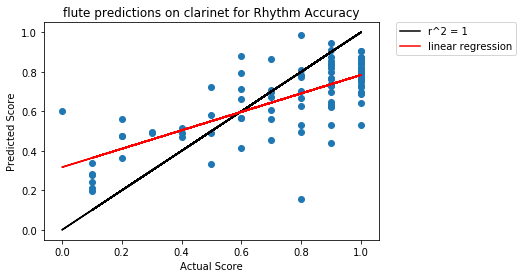

In [117]:
#print(targets.T.flatten())
m, b = np.polyfit(targets.cpu().T.flatten(), preds.cpu(), 1)
plot.scatter(targets.cpu(), preds.cpu())
plot.title(instrument+' predictions on '+ cross_instrument + ' for '+metric_type[METRIC])
plot.xlabel('Actual Score')
plot.ylabel('Predicted Score')
plot.plot(targets.cpu(), targets.cpu(), 'k', label='r^2 = 1')
plot.plot(targets.cpu(), targets.cpu() * m + b, 'r', label='linear regression')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Text(0, 0.5, 'Abs. Distance of prediction')

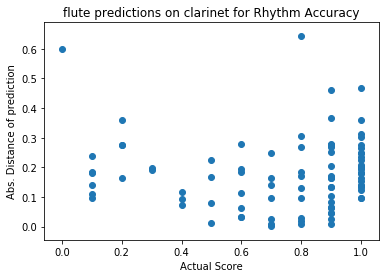

In [118]:
dist = np.abs(targets.cpu().T.flatten() - preds.cpu())
plot.scatter(targets.cpu(), dist.cpu())
plot.title(instrument+' predictions on '+ cross_instrument + ' for '+metric_type[METRIC])
plot.xlabel('Actual Score')
plot.ylabel('Abs. Distance of prediction')
#plot.plot(targets.cpu(), targets.cpu(), 'k', label='r^2 = 1')
#plot.plot(targets.cpu(), targets.cpu() * m + b, 'r', label='linear regression')
#plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [119]:
def r2(targ, pred):
    if len(targ) != len(pred):
        return 'targets length != predictions length'
    RSS = sum([(targ[i] - pred[i])**2 for i in range(len(targ))])
    mean = torch.mean(targ).item()
    TSS = sum([(targ[i] - mean)**2 for i in range(len(targ))])
    return 1 - (RSS/TSS).item()

In [120]:
print(r2(targets.flatten(), preds))

0.44393253326416016


In [121]:
def makeHist(instrument, metric, data):
    plot.figure()
    plot.hist(data, bins=20)
    plot.title('{0} - {1}'.format(instrument, metric))
    plot.show()

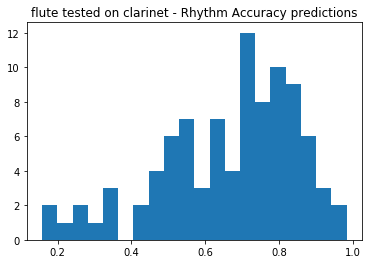

In [122]:
makeHist('{0} tested on {1}'.format(instrument, cross_instrument, metric_type[METRIC]), metric_type[METRIC] + ' predictions', preds.cpu())

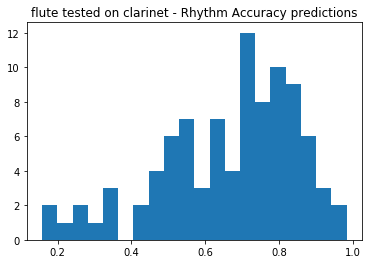

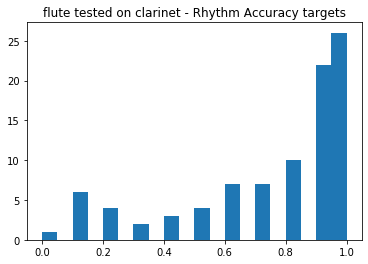

r2: 0.44393253326416016


In [123]:
makeHist('{0} tested on {1}'.format(instrument, cross_instrument, metric_type[METRIC]), metric_type[METRIC] + ' predictions', preds.cpu())
makeHist('{0} tested on {1}'.format(instrument, cross_instrument), metric_type[METRIC] + ' targets', targets.flatten().cpu())
print('r2: {}'.format(r2(targets.flatten(), preds)))

Mean X: 0.5000000596046448
Mean Y: 0.7499999403953552
r2 score: -1.9223525524139404
Linreg slope: 1.1999999826094527


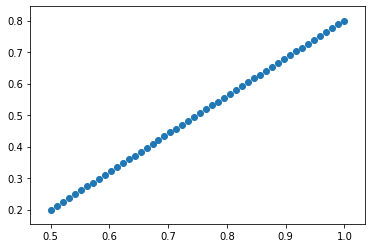

In [113]:
test_x = torch.Tensor(np.linspace(0.2, 0.8)) #50 samples
test_y = torch.Tensor(np.linspace(0.5, 1))   #50 samples
print('Mean X: {}'.format(torch.mean(test_x)))
print('Mean Y: {}'.format(torch.mean(test_y)))
print('r2 score: ' +str(r2(test_y, test_x)))
m, b = np.polyfit(test_y, test_x, 1)
print('Linreg slope: '+ str(m))
plot.scatter(test_y, test_x)
#print(metrics.r2_score(test_y, test_x))

In [124]:
print(torch.mean(targets))

tensor(0.7402)
